Implementing Tensorflow Neural machine translation with attention
Ref: https://www.tensorflow.org/text/tutorials/nmt_with_attention

In [20]:
import numpy as np
import typing
from typing import Any, Tuple
import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
import tensorflow_text as tf_text
from nltk.translate.bleu_score import corpus_bleu

In [21]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [24]:
# opening the train_source file in read mode
train_source_list = []
my_file = open("EncoderDecoder(Seq2Seq)/train-source.txt", "r", encoding='UTF-8')

data = my_file.read()
train_source_list = data.replace('\n'," ").split('<s>')
my_file.close()
for item in range(len(train_source_list)):
    train_source_list[item] = train_source_list[item].replace('</s>', '')

my_file.close()
train_source_list = np.array(train_source_list)

In [25]:
train_source_list[:5]

array(['',
       ' Cinnte go leór , thiocfadh dóbhtha bás a fhagháil ar imeall an phuill udaí .  ',
       ' ( Bhí sé follasach go rabh an poll sin ag foscladh ar an fhairrge ar dhóigh éigin , ná líonadh agus thráigheadh an t-uisce ann .  ',
       " ) D'fhéadfadh siad bás ' fhagháil ar a bhruach agus na cuirp imtheacht ar an lán mhara amach fríd an phluais .  ",
       ' Thiocfadh dóbhtha fosta lámh a chur ina mbás féin , a ghabháil de léim isteach sa pholl ghalach a bhí i n-iarthar an dara taibhlidh - poll mar bhéadh coire de uisce ghalach ann .  '],
      dtype='<U1193')

In [26]:
# opening the train_source file in read mode
my_file = open("EncoderDecoder(Seq2Seq)/train-target.txt", "r", encoding='UTF-8')

data = my_file.read()
train_target_list = data.replace('\n'," ").split('<s>')
my_file.close()
for item in range(len(train_target_list)):
    train_target_list[item] = train_target_list[item].replace('</s>', '')

my_file.close()
train_target_list = np.array(train_target_list)

In [27]:
train_target_list[:5]

array(['',
       ' Cinnte go leor , thiocfadh dóibh bás a fháil ar imeall an phoill úd .  ',
       ' Bhí sé follasach go raibh an poll sin ag foscladh ar an fharraige ar dhóigh éigin , nó líonadh agus thráigheadh an t-uisce ann .  ',
       " D'fhéadfadh siad bás a fháil ar a bhruach agus na coirp a imeacht ar an lán mhara amach fríd an phluais .  ",
       " Thiocfadh dóibh fosta lámh a chur ina mbás féin , a ghabháil de léim isteach sa pholl ghalach a bhí in iarthar an dara táibhle - poll mar a bheadh coire d'uisce ghalach ann .  "],
      dtype='<U1116')

In [28]:
is_train = np.random.uniform(size=(len(train_source_list),)) < 0.8

In [29]:
is_train[:5]

array([ True,  True,  True,  True,  True])

In [30]:
len(is_train)

45172

In [31]:
BUFFER_SIZE = len(train_source_list)
BATCH_SIZE = 8
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[is_train], train_target_list[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))
val_raw = (
    tf.data.Dataset
    .from_tensor_slices((train_source_list[~is_train], train_target_list[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

In [32]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b' " A Fheidhlimidh , a Fheidhlimidh , " arsa Toirdhealbhach .  '
 b' Bh\xc3\xad seisean agus a bhean le faobhar a chur ar a ch\xc3\xa9ile agus le buain i gcomhar .  '
 b" Chaithf\xc3\xad na h-ualaighe a \xc3\xa9adtromughadh a's ba chuma acht gan na Gaedhil an t-\xc3\xb3r a fhagh\xc3\xa1il .  "
 b' Chuala s\xc3\xa9 iomr\xc3\xa1dh go minic ar fhuadach fear ; agus a gcuala s\xc3\xa9 ariamh , th\xc3\xa1inig s\xc3\xa9 thr\xc3\xadd a cheann san am seo .  '
 b' Seachtmhain adubhairt bean amh\xc3\xa1in a chuirfeadh an bheirt bhan le ch\xc3\xa9ile ; m\xc3\xad a thug bean eile d\xc3\xb3ibh ; mhaoidh an tr\xc3\xadomhadh bean go mb\xc3\xa9adh siad ag caitheamh na teineadh ar a ch\xc3\xa9ile roimh r\xc3\xa1ithe .  '], shape=(5,), dtype=string)

tf.Tensor(
[b' " A Fheilim\xc3\xad , a Fheilim\xc3\xad ! " arsa Tarlach .  '
 b' Bh\xc3\xad seisean agus a bhean le faobhar a chur ar a ch\xc3\xa9ile agus le buain i gcomhar .  '
 b' Chaithf\xc3\xad na huala\xc3\xad a \xc3\xa9adrom\xc3\xba is ba

In [33]:
example_text = tf.constant(train_source_list[444])

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b" Ar mh\xc3\xa9ad ' s bh\xc3\xad de l\xc3\xbathgh\xc3\xa1ir orm as claonadh an \xc3\xa1idh in mo leith , d'\xc3\xa9irigh m\xc3\xa9 glionndrach suairc .  "
b" Ar mhe\xcc\x81ad ' s bhi\xcc\x81 de lu\xcc\x81thgha\xcc\x81ir orm as claonadh an a\xcc\x81idh in mo leith , d'e\xcc\x81irigh me\xcc\x81 glionndrach suairc .  "


In [34]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [35]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

 Ar mhéad ' s bhí de lúthgháir orm as claonadh an áidh in mo leith , d'éirigh mé glionndrach suairc .  
[START] ar mhead  s bhi de luthghair orm as claonadh an aidh in mo leith  ,  deirigh me glionndrach suairc  . [END]


Text Vectorization

In [36]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [37]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'a', 'an', ',', 'agus', 'ar']

In [38]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'a', 'an', ',', 'agus', 'ar']

In [39]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 5, 882, 7, 5, 882, 7, 22, 220, 4, 3],
 [2, 11, 71, 8, 5, 202, 20, 3017, 5, 109, 9, 5, 102, 8, 20, 1, 15, 3003, 4,
  3]                                                                       ,
 [2, 2537, 10, 1, 5, 1, 19, 34, 518, 28, 63, 10, 1236, 6, 2277, 5, 251, 4,
  3]                                                                      ]>

In [40]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] a fheidhlimidh , a fheidhlimidh , arsa toirdhealbhach . [END]'

Text(0.5, 1.0, 'Mask')

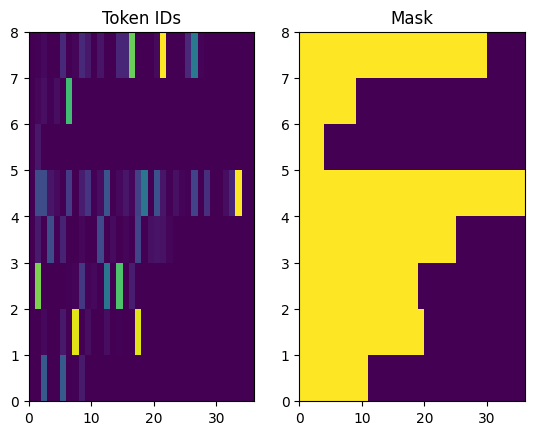

In [41]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

Process the dataset

In [42]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [43]:
#Here is first sequence of each bach
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  2  28  17  62   1   1  86  13 712  31]

[  2  19  20  17   1   1  70  14 571  32]
[  19   20   17    1    1   70   14  571   32 1492]


ENCODER DECODER

In [44]:
UNITS = 256

In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [46]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (8, 52)
Encoder output, shape (batch, s, units): (8, 52, 256)


In [47]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [48]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (8, 52, 256)
Target sequence, shape (batch, t, units): (8, 52, 256)
Attention result, shape (batch, t, units): (8, 52, 256)
Attention weights, shape (batch, t, s):    (8, 52, 52)


In [49]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.        , 0.99999994, 1.        , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.0000001 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       1.        , 0.99999994, 0.99999994, 1.        , 1.0000001 ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

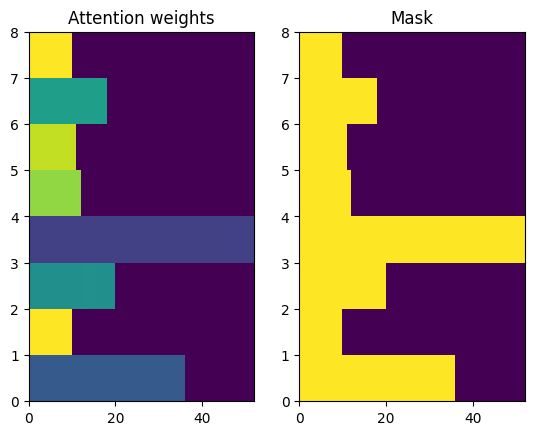

In [50]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


In [51]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [52]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [53]:
decoder = Decoder(target_text_processor, UNITS)

In [54]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (8, 52, 256)
input target tokens shape: (batch, t) (8, 52)
logits shape shape: (batch, target_vocabulary_size) (8, 52, 5000)


In [55]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [56]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [57]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

In [58]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'cosuil mhaoil ite seideadh loch tsamhradh chlainn carr mhillteanach uaigneas',
       b'den bhaoill bailte meanfach doigh satharn leadh leice meisce cainte',
       b'fhacthas mbfhearr bocht cuig chaptaen mic ghorm shaor inid aistioch'],
      dtype=object)

Model

In [59]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [60]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (8, 52)
Target tokens, shape: (batch, t) (8, 52)
logits, shape: (batch, t, target_vocabulary_size) (8, 52, 5000)


Training

In [61]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [62]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [63]:
#Configuring model for training:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

In [64]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

In [65]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 9s 38ms/step - loss: 8.5253 - masked_acc: 0.0000e+00 - masked_loss: 8.5253


{'loss': 8.52526569366455, 'masked_acc': 0.0, 'masked_loss': 8.52526569366455}

In [82]:
history = model.fit(
    train_ds.repeat(), 
    epochs=10,
    steps_per_epoch = 200,
    validation_data=val_ds,
    validation_steps = 30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/10
200/200 [==============================] - 25s 125ms/step - loss: 0.7238 - masked_acc: 0.8833 - masked_loss: 0.7238 - val_loss: 0.7067 - val_masked_acc: 0.8856 - val_masked_loss: 0.7067
Epoch 2/10
103/200 [==============>...............] - ETA: 11s - loss: 0.7146 - masked_acc: 0.8827 - masked_loss: 0.7146

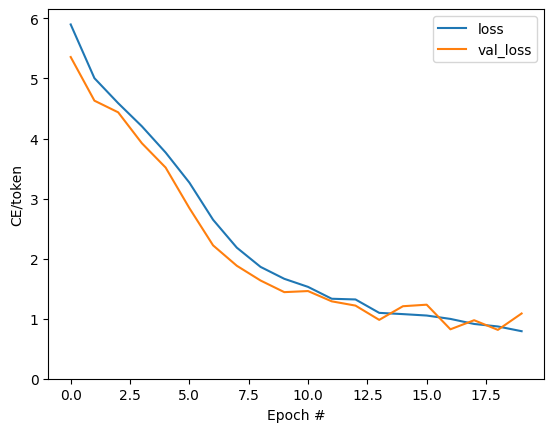

In [67]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

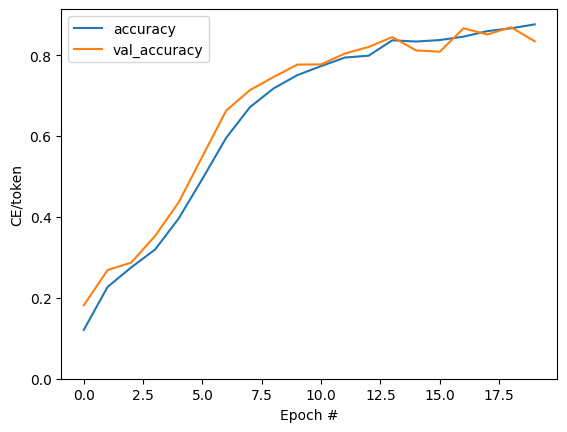

In [68]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

Translate

In [69]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

In [70]:
result = model.translate(['Cinnte go leór , thiocfadh dóbhtha bás a fhagháil ar imeall an phuill udaí .'])
result[0].numpy().decode()

'cinnte go leor , a leor , a fhail ar imeall an ghuail sin . '

In [71]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

C:\Users\brije\AppData\Local\Temp\ipykernel_44740\3355722706.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
C:\Users\brije\AppData\Local\Temp\ipykernel_44740\3355722706.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output, fontdict=fontdict)


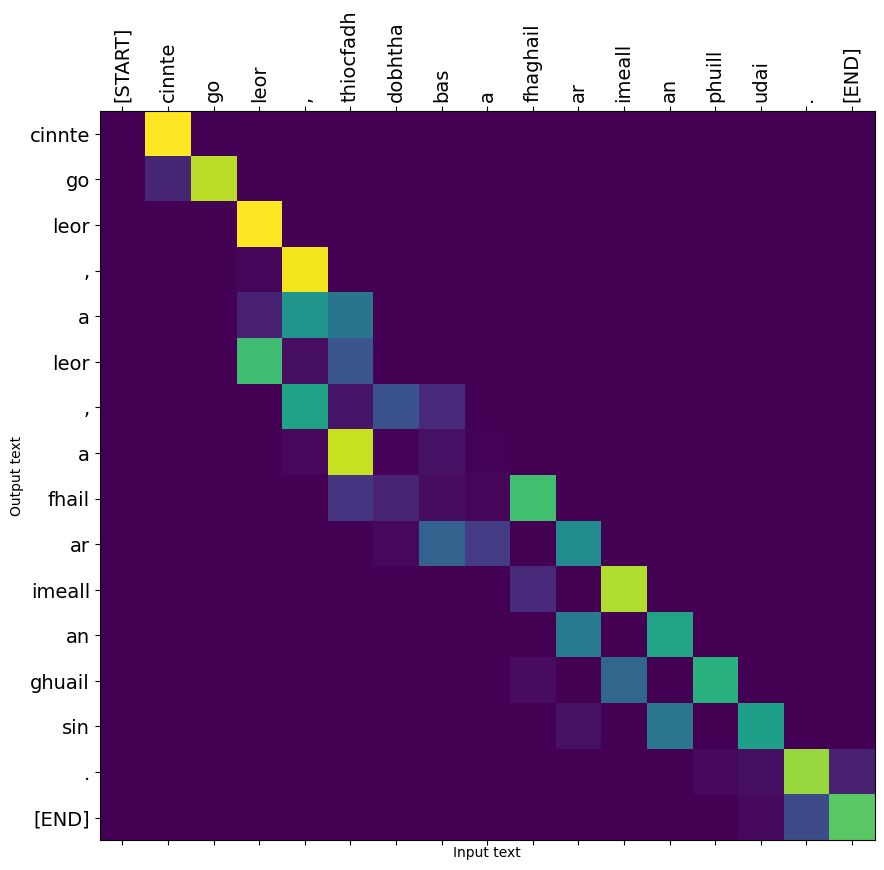

In [72]:
model.plot_attention('Cinnte go leór , thiocfadh dóbhtha bás a fhagháil ar imeall an phuill udaí .') 

Working on Test Set 

In [73]:
!pip install unidecode

In [74]:
# opening the train_source file in read mode
test_source_list = []
my_file = open("EncoderDecoder(Seq2Seq)/test-source.txt", "r", encoding='UTF-8')

data = my_file.read()
test_source_list = data.replace('\n'," ").split('<s>')
my_file.close()
for item in range(len(test_source_list)):
    test_source_list[item] = test_source_list[item].replace('</s>', '')

my_file.close()
test_source_list = np.array(test_source_list)

In [75]:
# opening the train_source file in read mode
test_target_list = []
my_file = open("EncoderDecoder(Seq2Seq)/test-target.txt", "r", encoding='UTF-8')

data = my_file.read()
test_target_list = data.replace('\n'," ").split('<s>')
my_file.close()
for item in range(len(test_target_list)):
    test_target_list[item] = test_target_list[item].replace('</s>', '')

my_file.close()
test_target_list = np.array(test_target_list)

In [76]:
predicted=[]
actual=[]
for i in range(len(test_source_list)):
    prediction = model.translate([test_source_list[i]])
    prediction = prediction[0].numpy().decode()
    predicted.append(prediction)
    target_vals=test_target_list[i]
    actual.append(target_vals)

BLEU SCORE

In [77]:
#Aything Goes
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu 
print(corpus_bleu([[i] for i in actual], predicted))

0.5804221310942163
